# Gym.OpenAI : Frozen Lake - Introduction to Deep Q-Learning

OpenAI environment : https://gym.openai.com/envs/FrozenLake-v0/

Here I wanted to realize a deep Q-network from scratch by my own, using pyTorch. I implemented it basically, without any Replay Memory or Eligibility Trace, to really understand how a basic deep Q-network was working.

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

SFFF       (S: starting point, safe)  
FHFH       (F: frozen surface, safe)  
FFFH       (H: hole, fall to your doom)  
HFFG       (G: goal, where the frisbee is located)

In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch
import time

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

import gym

C:\Users\Portable\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
env = gym.make('FrozenLake-v0')
nb_neurons = 45
#temperature = 1
learning_rate = 0.05
gamma = 0.99
e = 0.2
number_episodes = 2000

all_reward = []

In [3]:
class brain(nn.Module):
    
    def __init__(self):
        super(brain,self).__init__()
        self.fc1 = nn.Linear(env.observation_space.n,nb_neurons)
        self.fc2 = nn.Linear(nb_neurons,env.action_space.n)
    
    def forward(self,state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

In [4]:
class DQN():
    def __init__(self,gamma):
        self.model=brain()
        self.gamma = gamma
        self.optimizer = optim.SGD(self.model.parameters(), lr = learning_rate)
        
    def select_action(self,state):
        #probs=F.softmax(self.model(torch.Tensor(state).detach())*temperature)
        #action = probs.multinomial(4)
        output = self.model(torch.Tensor(state).detach()).data
        action = np.argmax(output)
        if np.random.rand(1)<e:
            action = env.action_space.sample()
        return action
    
    def learn(self, current_state, next_state,reward,action,done):
        output = self.model(current_state)
        next_output = self.model(next_state).detach()
        target = (reward + self.gamma*(next_output.detach().max()[0]))
        if done:
            target = torch.Tensor([reward])
        td_loss = F.smooth_l1_loss(output[action], target)
        
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()
        

Let's have a look at the initial weights :

In [5]:
ai = DQN(gamma)

for i in range(env.observation_space.n):
    print (ai.model(torch.Tensor((to_categorical(i, num_classes = 16))).squeeze(0)))

tensor([-0.3365,  0.0989, -0.0208,  0.0498], grad_fn=<ThAddBackward>)
tensor([-0.3551,  0.0762,  0.0167,  0.0112], grad_fn=<ThAddBackward>)
tensor([-0.2144,  0.0657, -0.0687, -0.0081], grad_fn=<ThAddBackward>)
tensor([-0.3639,  0.0541,  0.0408,  0.0614], grad_fn=<ThAddBackward>)
tensor([-0.2373,  0.0049, -0.0651,  0.0248], grad_fn=<ThAddBackward>)
tensor([-0.3607,  0.0225, -0.0104,  0.0261], grad_fn=<ThAddBackward>)
tensor([-0.3975,  0.0774,  0.0613,  0.0664], grad_fn=<ThAddBackward>)
tensor([-0.1656,  0.0688,  0.0381, -0.0737], grad_fn=<ThAddBackward>)
tensor([-0.2867,  0.0602, -0.0726,  0.0368], grad_fn=<ThAddBackward>)
tensor([-0.2483,  0.0600, -0.0234, -0.0442], grad_fn=<ThAddBackward>)
tensor([-0.2502,  0.0440, -0.0178, -0.0657], grad_fn=<ThAddBackward>)
tensor([-0.2740,  0.0430, -0.0662, -0.0250], grad_fn=<ThAddBackward>)
tensor([-0.2278,  0.0579, -0.0687,  0.0282], grad_fn=<ThAddBackward>)
tensor([-0.2770,  0.0167, -0.0824, -0.0171], grad_fn=<ThAddBackward>)
tensor([-0.2907,  0.

# Learning

Now we can go through our episodes and realize the learning :

In [6]:
for episode in range(number_episodes):
    #e=0.2-episode/number_episodes
    if episode == 1000:
        e=0
    current_state = torch.Tensor(to_categorical(env.reset(), num_classes = 16))
    cumulative_reward = 0
    
    for t in range(100):
        action = ai.select_action(current_state)
        next_state, reward, done, _ = env.step(np.int64(action))      
        next_state = to_categorical(next_state, num_classes = 16)
        cumulative_reward+=reward
        #env.render()
        ai.learn(torch.Tensor(current_state),torch.Tensor(next_state),reward,action,done)
        if done:                
            break
        
        current_state = next_state
    all_reward.append(cumulative_reward)

C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


# Results

In [7]:
learning = []
y = []
batch_size = 100
for i in range(0,len(all_reward),batch_size):
    learning.append(sum(all_reward[i:i+batch_size])/batch_size)
    y.append(i)

Text(0.5,1,'Evolution of the average reward')

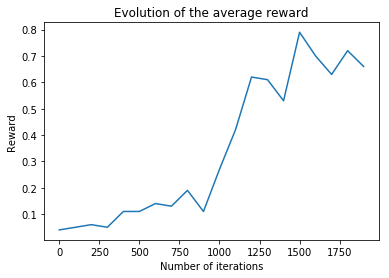

In [8]:
plt.plot(y,learning)
plt.ylabel('Reward')
plt.xlabel('Number of iterations')
plt.title('Evolution of the average reward')

After the 1000th iteration, we stop to do 20% of random moves, that's why the average reward improved.

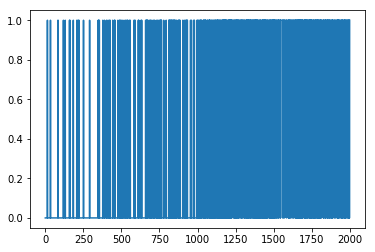

In [9]:
plt.plot(all_reward)

### Reference:

Deep Q-network with TensorFlow:  
https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0